In [1]:
import json

books = []

with open('found_books_filtered.ndjson', 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

Found 38665 books.


In [2]:
book_list = []
link_list = []
for book in books:
    book_list += [book[0]]
    link_list += book[2]

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter([len(book[2]) for book in books])
plt.bar(x = counts.keys(), height = counts.values())
plt.show()
print('Minimum number of links is',min(counts.values()))

<Figure size 640x480 with 1 Axes>

Minimum number of links is 1


In [4]:
# check the most common links too see if they are meaningful
counter = Counter(link_list)
sorted(counter.items(), key = lambda x : x[1], reverse = True)[:50]

[('Hardcover', 7637),
 ('Paperback', 7457),
 ('Wikipedia:WikiProject Books', 6188),
 ('Wikipedia:WikiProject Novels', 6159),
 ('The New York Times', 4609),
 ('English language', 4130),
 ('United States', 3237),
 ('Science fiction', 3187),
 ('Publishers Weekly', 2790),
 ('science fiction', 2762),
 ('The Guardian', 2627),
 ('Kirkus Reviews', 2156),
 ('novel', 2022),
 ('paperback', 1585),
 ('Random House', 1538),
 ('HarperCollins', 1537),
 ('Doctor Who', 1332),
 ('fantasy', 1316),
 ('Category:American science fiction novels', 1313),
 ('hardcover', 1308),
 ('Category:American novels adapted into films', 1202),
 ('Simon  &  Schuster', 1186),
 ('Category:English-language books', 1175),
 ("Children's literature", 1170),
 ('Category:Debut novels', 1122),
 ('World War II', 1098),
 ('Fantasy novel', 1078),
 ('Doubleday (publisher)', 1071),
 ('The Washington Post', 1069),
 ('Category:American fantasy novels', 1066),
 ('New York Times', 1063),
 ('Novel', 1005),
 ('Category:American young adult nov

In [5]:
# pick some meaningless links by hand
meaningless = ['Hardcover', 'Paperback', 'Wikipedia:WikiProject Books', 'Wikipedia:WikiProject Novels', 'The New York Times', 'English language',
               'Publishers Weekly', 'Novel', 'novel', 'paperback', 'hardcover', 'Doubleday (publisher)', 'Hardback', 'Booklist']

Total number of books considered 38665


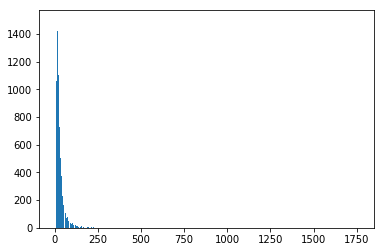

Minimum number of links is 1


In [6]:
# create a source and check number of links for each book
source = {}
for book in books:
    book_name = book[0]
    links = [link for link in book[2] if link not in meaningless]
    source.update({book_name:links})

print('Total number of books considered', len(source))
counts = Counter([len(links) for links in source.values()])
plt.bar(x = counts.keys(), height = counts.values())
plt.show()
print('Minimum number of links is',min(counts.values()))# make sure the minimum number is not 0

In [7]:
book_list = list(set(book_list))
link_list = list(set(link_list) - set(meaningless))
len(book_list), len(link_list)

(38665, 327511)

In [8]:
book_to_num = dict(zip(book_list, range(len(book_list))))
link_to_num = dict(zip(link_list, range(len(link_list))))

In [9]:
num_to_book = dict(zip(book_to_num.values(), book_to_num.keys()))
num_to_link = dict(zip(link_to_num.values(), link_to_num.keys()))

In [10]:
# to make things faster we use multiprocessing
# without multiprocessing it's like 93s/1000 books on my laptop[]

import time
import random 
import numpy as np
from multiprocessing import Pool

num_neg_sample = 5
ratio_neg_sample = None

X = []
Y = []
t_start = time.time()
if num_neg_sample is None or num_neg_sample<=0 or num_neg_sample>20:
    num_neg_sample = 10
if ratio_neg_sample is not None:
    if ratio_neg_sample > 2:
        ratio_neg_sample = 1
def process_one_book(item):
    book, links = item
    X = []
    y = []
    for link in links:
        X.append([book_to_num[book], link_to_num[link]])
        y.append([1])
    not_linked = set(link_list)-set(links)
    if ratio_neg_sample is None:
        num = min(len(not_linked)-1, num_neg_sample)
    else:
        num = min(len(not_linked)-1, ratio_neg_sample*len(source[book]))
    for link in random.sample(not_linked, num):
        X.append([book_to_num[book], link_to_num[link]])
        y.append([0])
    return X, y
pool = Pool(10)
results = pool.map(process_one_book, source.items())
for x, y in results:
    X += x
    Y += y
print('Time Usage :', time.time() - t_start)

np.save('train_X.npy', np.array(X))
np.save('train_y.npy', np.array(Y))

Time Usage : 1225.8569149971008


In [11]:
# the version without multiprocessing, just to compare time

import tqdm

def generate_training_set(source, ratio_neg_sample=None, num_neg_sample=5):
    '''
    source should be a dictionary of (book : links) pairs
    ratio_neg_sample is the ratio of negative samples and positive samples for each book, maximum 2
    num_neg_samples is the number of negative samples for each book, maximum 20
    num_reg_samples will be activate if ratio_neg_sample is None
    '''
    X = []
    y = []
    if num_neg_sample is None or num_neg_sample<=0 or num_neg_sample>20:
        num_neg_sample = 10
    if ratio_neg_sample is not None:
        if ratio_neg_sample > 2:
            ratio_neg_sample = 1
    for book in tqdm.tqdm(source.keys()):
        for link in source[book]:
            X.append([book_to_num[book], link_to_num[link]])
            y.append([1])
        not_linked = set(link_list)-set(source[book])
        if ratio_neg_sample is None:
            num = min(len(not_linked)-1, num_neg_sample)
        else:
            num = min(len(not_linked)-1, ratio_neg_sample*len(source[book]))
        for link in random.sample(not_linked, num):
            X.append([book_to_num[book], link_to_num[link]])
            y.append([0])
    return np.array(X), np.array(y)

train = generate_training_set(source)

#np.save('train_X.npy', train[0])
#np.save('train_y.npy', train[1])

100%|██████████| 38665/38665 [1:01:24<00:00, 10.49it/s]


In [12]:
#build, compile the model
import tensorflow as tf
from keras import optimizers
from keras import backend as K
from keras.layers import *
from keras.models import Model

def generate_model(length):
    Embedding1 = Embedding(len(book_list), length, name='books')
    Embedding2 = Embedding(len(link_list), length, name='links')
    squeeze_layer = Lambda(lambda x : K.squeeze(x, axis=1))
    books = Input(shape=(1,))
    links = Input(shape=(1,))
    X1 = Embedding1(books)
    X2 = Embedding2(links)
    squeezed_X1 = squeeze_layer(X1)
    squeezed_X2 = squeeze_layer(X2)
    output = Dot(axes=-1, normalize=True)([squeezed_X1, squeezed_X2])
    output = Activation('sigmoid')(output)
    model = Model(inputs = [books, links], outputs=[output])
    return model

model = generate_model(50)
model.compile(optimizer=optimizers.Adam(0.001), loss='binary_crossentropy')
model.summary()

/Users/lifengwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
books (Embedding)               (None, 1, 50)        1933250     input_1[0][0]                    
__________________________________________________________________________________________________
links (Embedding)               (None, 1, 50)        16375550    input_2[0][0]                    
_____________________________________

Using TensorFlow backend.


In [13]:
X = np.load('train_X.npy')
Y = np.load('train_y.npy')
books = X[:, [0]].astype('int')
links = X[:, [1]].astype('int')
labels = Y.astype('int')
model.fit(x=[books, links], y=labels, batch_size=512, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1405479/1405479 [==============================] - 556s 396us/step - loss: 0.6457
Epoch 2/20
1405479/1405479 [==============================] - 561s 399us/step - loss: 0.4744
Epoch 3/20
1405479/1405479 [==============================] - 568s 404us/step - loss: 0.4284
Epoch 4/20
1405479/1405479 [==============================] - 561s 399us/step - loss: 0.4138
Epoch 5/20
1405479/1405479 [==============================] - 555s 395us/step - loss: 0.4071
Epoch 6/20
1405479/1405479 [==============================] - 559s 397us/step - loss: 0.4033
Epoch 7/20
1405479/1405479 [==============================] - 560s 398us/step - loss: 0.4006
Epoch 8/20
1405479/1405479 [==============================] - 559s 398us/step - loss: 0.3986
Epoch 9/20
1405479/1405479 [==============================] - 559s 398us/step - loss: 0.3969
Epoch 10/20
1405479/1405479 [==============================] - 559s 398us/step - loss: 0.3955
Epoch 11/20
1405479/1

In [14]:
book_vectors = model.get_layer('books').get_weights()[0]
book_vectors /= np.sqrt(np.sum(book_vectors**2, axis=1, keepdims=True)+1e-6)#normalize
book_vectors.shape

(38665, 50)

In [15]:
def recommend_books(book_name, book_vectors, n=10):
    if book_name not in book_list:
        print('No such book')
        return None
    else:
        vector = book_vectors[[book_to_num[book_name]], :]
        inner_products = np.sum(vector*book_vectors, axis=1)
        results = list(np.argsort(inner_products)[-(n+1):])
        results.reverse()
        return [num_to_book[num] for num in results[1:]]

In [16]:
recommend_books('Timescape', book_vectors, 10)

['Drakon (novel)',
 'Battlefield Earth (novel)',
 'Walkaway (Doctorow novel)',
 'Scythe (novel)',
 'Camouflage (novel)',
 'Empire (Card novel)',
 'Unwind (novel)',
 'The Accidental Time Machine',
 'Deadline (Grant novel)',
 'Annihilation (VanderMeer novel)']